In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn import compose

from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# from sklearn_evaluation import plot

In [3]:
data_df = pd.read_csv('heart.csv')
sex_oh_enc = pd.get_dummies(data_df["Sex"], dtype="int").rename(columns={"F":"Female", "M":"Male"})
chestPain_oh_enc = pd.get_dummies(data_df["ChestPainType"], dtype="int").rename(columns={"TA":"ChestPain_TA", "ATA":"ChestPain_ATA", "NAP":"ChestPain_NAP","ASY":"ChestPain_ASY"})
restECG_oh_enc = pd.get_dummies(data_df["RestingECG"], dtype="int").rename(columns={"Normal":"RestECG_Normal", "ST":"RestECG_ST", "LVH":"RestECG_LVH"})
st_slope_oh_enc = pd.get_dummies(data_df["ST_Slope"], dtype="int").rename(columns={"Up":"ST_Slope_Up", "Flat":"ST_Slope_Flat", "Down":"ST_Slope_Down"})
exerciseAngina_ord_enc = pd.DataFrame(pd.factorize(data_df["ExerciseAngina"])[0], columns=["ExerciseAngina"])

data_df_encoded = data_df.drop(columns=["Sex", "ChestPainType", "RestingECG", "ST_Slope", "ExerciseAngina"])
data_df_encoded = data_df_encoded.join([sex_oh_enc, chestPain_oh_enc, restECG_oh_enc, st_slope_oh_enc, exerciseAngina_ord_enc])
data_df_encoded = data_df_encoded[["Age",
                                  "Male", "Female",
                                  "ChestPain_TA", "ChestPain_ATA", "ChestPain_NAP", "ChestPain_ASY",
                                  "RestingBP",
                                  "Cholesterol",
                                  "FastingBS",
                                  "RestECG_Normal", "RestECG_ST", "RestECG_LVH",
                                  "MaxHR",
                                  "ExerciseAngina",
                                  "Oldpeak",
                                  "ST_Slope_Up", "ST_Slope_Flat", "ST_Slope_Down",
                                  "HeartDisease"]]
categorical_columns = ["Male", "Female", "ChestPain_TA", "ChestPain_ATA", "ChestPain_NAP", "ChestPain_ASY", "FastingBS", "RestECG_Normal", "RestECG_ST", "RestECG_LVH", "ExerciseAngina", "ST_Slope_Up", "ST_Slope_Flat", "ST_Slope_Down", "HeartDisease"]
for col in categorical_columns:
    data_df_encoded[col] = data_df_encoded[col].astype("category")
feature_names = data_df_encoded.columns
data_df_encoded

,Age,Male,Female,ChestPain_TA,ChestPain_ATA,ChestPain_NAP,ChestPain_ASY,RestingBP,Cholesterol,FastingBS,RestECG_Normal,RestECG_ST,RestECG_LVH,MaxHR,ExerciseAngina,Oldpeak,ST_Slope_Up,ST_Slope_Flat,ST_Slope_Down,HeartDisease
0,40,1,0,0,1,0,0,140,289,0,1,0,0,172,0,0.0,1,0,0,0
1,49,0,1,0,0,1,0,160,180,0,1,0,0,156,0,1.0,0,1,0,1
2,37,1,0,0,1,0,0,130,283,0,0,1,0,98,0,0.0,1,0,0,0
3,48,0,1,0,0,0,1,138,214,0,1,0,0,108,1,1.5,0,1,0,1
4,54,1,0,0,0,1,0,150,195,0,1,0,0,122,0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,0,1,0,0,0,110,264,0,1,0,0,132,0,1.2,0,1,0,1
914,68,1,0,0,0,0,1,144,193,1,1,0,0,141,0,3.4,0,1,0,1
915,57,1,0,0,0,0,1,130,131,0,1,0,0,115,1,1.2,0,1,0,1
916,57,0,1,0,1,0,0,130,236,0,0,0,1,174,0,0.0,0,1,0,1


In [4]:
X = np.array(data_df_encoded)[:,:-1]
y = np.array(data_df_encoded)[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=8)

In [5]:
# Normalize age, RestingBP, Cholesterol, MaxHR, and oldPeak

# Standardization (Z-score normzalization): zero-centered & unit variance
ct_std = compose.ColumnTransformer([("standard_scaler", preprocessing.StandardScaler(), [0, 7, 8, 13, 15])], remainder="passthrough")

# Min/Max Normalization (Linear Scaling): [0,1]
ct_mm = compose.ColumnTransformer([("min_max_scaler", preprocessing.MinMaxScaler(), [0, 7, 8, 13, 15])], remainder="passthrough")

X_train_std = ct_std.fit_transform(X_train)
X_test_std = ct_mm.fit_transform(X_test)
X_train_mm = ct_std.fit_transform(X_train)
X_test_mm = ct_mm.fit_transform(X_test)

In [6]:
# Transformations
X_train_us_polys = {}
X_test_us_polys = {}

X_train_std_polys = {}
X_test_std_polys = {}

X_train_mm_polys = {}
X_test_mm_polys = {}

model_degrees = range(1,3)

for degree in model_degrees:
    poly = preprocessing.PolynomialFeatures(degree)
    
    X_train_us_polys[degree] = poly.fit_transform(X_train)
    X_test_us_polys[degree] = poly.fit_transform(X_test)
    
    X_train_std_polys[degree] = poly.fit_transform(X_train_std)
    X_test_std_polys[degree] = poly.fit_transform(X_test_std)

    X_train_mm_polys[degree] = poly.fit_transform(X_train_mm)
    X_test_mm_polys[degree] = poly.fit_transform(X_test_mm)

Normalization: unscaled | Degree: 1
Activation Function, Hidden Layers, alpha = 0 (train), alpha = 0 (test), alpha = 0.001 (train), alpha = 0.001 (test), alpha = 0.01 (train), alpha = 0.01 (test), alpha = 0.1 (train), alpha = 0.1 (test), alpha = 0.5 (train), alpha = 0.5 (test), alpha = 1 (train), alpha = 1 (test)
logistic, "(10, 5)",0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878
logistic, "15",0.7472796071393791, 0.726151444184231,0.7472796071393791, 0.726151444184231,0.7472796071393791, 0.726151444184231,0.7479612703977296, 0.726151444184231,0.7465979438810288, 0.7275119884019182,0.745912107174158, 0.7275342924054868
logistic, "10",0.7554540016415564, 0.7534180885468942,0.7554540016415564, 0.7534180885468942,0.7554540016415564, 0.7534180885468942,0.7568173281582572, 0.7534180885468942,0.75340901186650

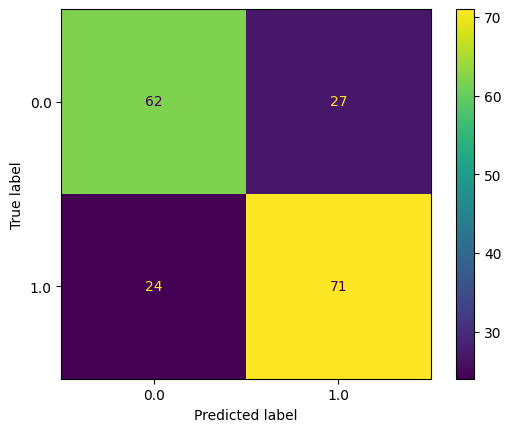

Normalization: standardization | Degree: 1
Activation Function, Hidden Layers, alpha = 0 (train), alpha = 0 (test), alpha = 0.001 (train), alpha = 0.001 (test), alpha = 0.01 (train), alpha = 0.01 (test), alpha = 0.1 (train), alpha = 0.1 (test), alpha = 0.5 (train), alpha = 0.5 (test), alpha = 1 (train), alpha = 1 (test)
logistic, "(10, 5)",0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878
logistic, "15",0.8549128444833967, 0.8501561280249805,0.8549128444833967, 0.8501561280249805,0.8549128444833967, 0.8501561280249805,0.8555931165922401, 0.8474294635887141,0.8562747798505904, 0.844702799152448,0.8549114533338898, 0.8433366789338687
logistic, "10",0.8549142356329035, 0.850172856027657,0.8549142356329035, 0.850172856027657,0.8549142356329035, 0.850172856027657,0.8542325723745531, 0.8488123118099699,0.852869

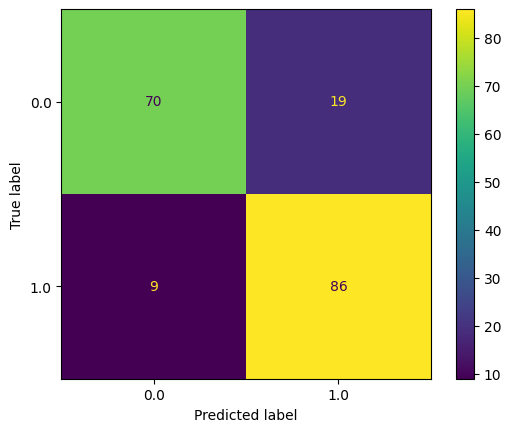

Normalization: min-max scaled | Degree: 1
Activation Function, Hidden Layers, alpha = 0 (train), alpha = 0 (test), alpha = 0.001 (train), alpha = 0.001 (test), alpha = 0.01 (train), alpha = 0.01 (test), alpha = 0.1 (train), alpha = 0.1 (test), alpha = 0.5 (train), alpha = 0.5 (test), alpha = 1 (train), alpha = 1 (test)
logistic, "(10, 5)",0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878
logistic, "15",0.8549128444833967, 0.8501561280249805,0.8549128444833967, 0.8501561280249805,0.8549128444833967, 0.8501561280249805,0.8555931165922401, 0.8474294635887141,0.8562747798505904, 0.844702799152448,0.8549114533338898, 0.8433366789338687
logistic, "10",0.8549142356329035, 0.850172856027657,0.8549142356329035, 0.850172856027657,0.8549142356329035, 0.850172856027657,0.8542325723745531, 0.8488123118099699,0.8528692

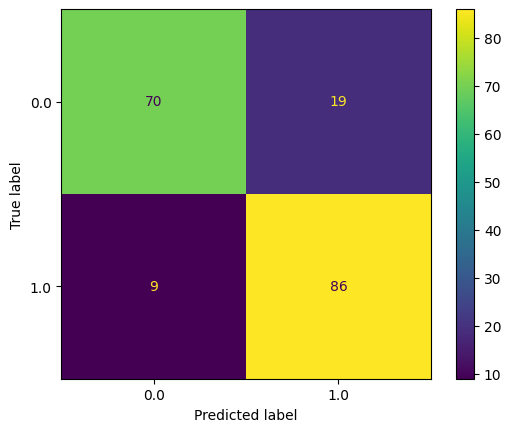

Normalization: unscaled | Degree: 2
Activation Function, Hidden Layers, alpha = 0 (train), alpha = 0 (test), alpha = 0.001 (train), alpha = 0.001 (test), alpha = 0.01 (train), alpha = 0.01 (test), alpha = 0.1 (train), alpha = 0.1 (test), alpha = 0.5 (train), alpha = 0.5 (test), alpha = 1 (train), alpha = 1 (test)
logistic, "(10, 5)",0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878
logistic, "15",0.6008430366011436, 0.5871584699453551,0.5626698941335225, 0.5626686740269878,0.5129084762739452, 0.5164101706256273,0.6022063631178444, 0.5912401025984164,0.5626698941335225, 0.5626686740269878,0.5129084762739452, 0.5164101706256273
logistic, "10",0.5619882308751721, 0.5613081298093009,0.5619882308751721, 0.5613081298093009,0.5619882308751721, 0.5613081298093009,0.5613079587663287, 0.5613081298093009,0.560627686

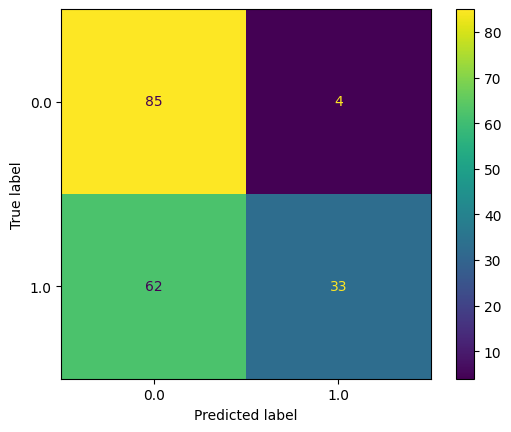

Normalization: standardization | Degree: 2
Activation Function, Hidden Layers, alpha = 0 (train), alpha = 0 (test), alpha = 0.001 (train), alpha = 0.001 (test), alpha = 0.01 (train), alpha = 0.01 (test), alpha = 0.1 (train), alpha = 0.1 (test), alpha = 0.5 (train), alpha = 0.5 (test), alpha = 1 (train), alpha = 1 (test)
logistic, "(10, 5)",0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878
logistic, "15",0.8910062184382955, 0.8705642912902866,0.8910062184382955, 0.8705642912902866,0.8910062184382955, 0.8719304115088659,0.890325946329452, 0.8746626519460244,0.8869218034862206, 0.8733021077283372,0.8862401402278702, 0.8746626519460244
logistic, "10",0.8944131435805406, 0.873296531727445,0.8944131435805406, 0.873296531727445,0.8944131435805406, 0.873296531727445,0.8944131435805406, 0.8719304115088659,0.891006

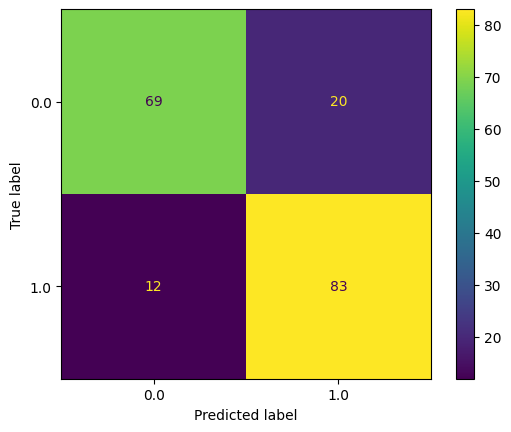

Normalization: min-max scaled | Degree: 2
Activation Function, Hidden Layers, alpha = 0 (train), alpha = 0 (test), alpha = 0.001 (train), alpha = 0.001 (test), alpha = 0.01 (train), alpha = 0.01 (test), alpha = 0.1 (train), alpha = 0.1 (test), alpha = 0.5 (train), alpha = 0.5 (test), alpha = 1 (train), alpha = 1 (test)
logistic, "(10, 5)",0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878,0.5626698941335225, 0.5626686740269878
logistic, "15",0.8910062184382955, 0.8705642912902866,0.8910062184382955, 0.8705642912902866,0.8910062184382955, 0.8719304115088659,0.890325946329452, 0.8746626519460244,0.8869218034862206, 0.8733021077283372,0.8862401402278702, 0.8746626519460244
logistic, "10",0.8944131435805406, 0.873296531727445,0.8944131435805406, 0.873296531727445,0.8944131435805406, 0.873296531727445,0.8944131435805406, 0.8719304115088659,0.8910062

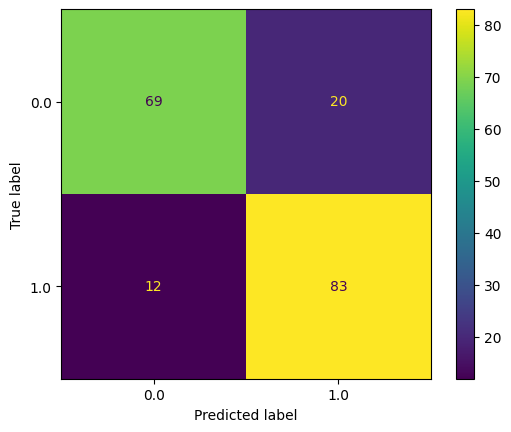

In [8]:
# Neural Network
pipe = Pipeline(steps=[('neural_net', MLPClassifier(solver='sgd', random_state=8, max_iter=10000))])
param_grid = {
    "neural_net__hidden_layer_sizes": [(10, 5), (15), (10), (5)],
    "neural_net__activation": ['logistic', 'tanh', 'relu'],
    "neural_net__alpha": [0, 0.001, 0.01, 0.1, 0.5, 1],
}
search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=4, return_train_score=True)

def show_nn_results(search, normalization, degree, X_train, X_test):
    results_df = pd.DataFrame(search.cv_results_).get(["param_neural_net__activation", "param_neural_net__hidden_layer_sizes", "param_neural_net__alpha", "mean_test_score", "mean_train_score"])
    
    activations = search.param_grid["neural_net__activation"]
    layers = search.param_grid["neural_net__hidden_layer_sizes"]
    alphas = search.param_grid["neural_net__alpha"]
    
    print("Normalization:", normalization, "| Degree:", degree)
    print("Activation Function, Hidden Layers", end="")
    for alpha in alphas:
        print(f", alpha = {alpha} (train), alpha = {alpha} (test)", end="", sep="")
    print()
    for activation in activations:
        df_activation = results_df[results_df["param_neural_net__activation"] == activation]
        for layer in layers:
            df_layer = df_activation[df_activation["param_neural_net__hidden_layer_sizes"] == layer]
            alpha_vals_train = {}
            alpha_vals_test = {}
            for alpha in alphas:
                alpha_vals_train[alpha] = df_layer[df_layer["param_neural_net__alpha"] == alpha]["mean_train_score"].iat[0]
                alpha_vals_test[alpha] = df_layer[df_layer["param_neural_net__alpha"] == alpha]["mean_test_score"].iat[0]
            print(f"{activation}, \"{str(layer)}\","\
                  f"{alpha_vals_train[0]}, {alpha_vals_test[0]},"\
                  f"{alpha_vals_train[0.001]}, {alpha_vals_test[0.001]},"\
                  f"{alpha_vals_train[0.01]}, {alpha_vals_test[0.01]},"\
                  f"{alpha_vals_train[0.1]}, {alpha_vals_test[0.1]},"\
                  f"{alpha_vals_train[0.5]}, {alpha_vals_test[0.5]},"\
                  f"{alpha_vals_train[1]}, {alpha_vals_test[1]}")
    
    print(normalization + ", degree", degree)
    print("Best: ", search.best_params_) 
    print("\tTraining:\n", classification_report(y_train, search.best_estimator_.predict(X_train)))
    print("\tTest:\n", classification_report(y_test, search.best_estimator_.predict(X_test)))
    
    
    y_pred = search.best_estimator_.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()

cv_results_and_params = {}

pd.set_option('display.max_rows', 110)
for degree in model_degrees:
    cv_results_and_params[degree] = []

    search.fit(X_train_us_polys[degree], y_train)
    cv_results_and_params[degree].append((search.cv_results_, search.param_grid))
    show_nn_results(search, "unscaled", degree, X_train_us_polys[degree], X_test_us_polys[degree])

    search.fit(X_train_std_polys[degree], y_train)
    cv_results_and_params[degree].append((search.cv_results_, search.param_grid))
    show_nn_results(search, "standardization", degree, X_train_std_polys[degree], X_test_std_polys[degree])

    search.fit(X_train_mm_polys[degree], y_train)
    cv_results_and_params[degree].append((search.cv_results_, search.param_grid))
    show_nn_results(search, "min-max scaled", degree, X_train_mm_polys[degree], X_test_mm_polys[degree])

In [69]:
def plot_nn_cv_results(cv_results_, param_grid, normalization, degree):
    df = pd.DataFrame(cv_results_)
    layer_sizes = param_grid["neural_net__hidden_layer_sizes"]
    activations = param_grid["neural_net__activation"]

    fig, axes = plt.subplots(2, 2, figsize=(15,10))

    def score_graph(ax, layer_size):
        colors = ["red", "green", "blue"]
        for activation, color in zip(activations, colors):
            kernel_rows = df[(df["param_neural_net__hidden_layer_sizes"] == layer_size) & (df["param_neural_net__activation"] == activation)]
            ax.plot(kernel_rows["param_neural_net__alpha"], kernel_rows["mean_train_score"], color=color, label=f"{activation} (train)")
            ax.plot(kernel_rows["param_neural_net__alpha"], kernel_rows["mean_test_score"], linestyle="dashed", color=color, label=f"{activation} (test)")
        ax.set_xlabel("C")
        ax.set_ylabel("Score")
        ax.set_ylim(0.4, 0.9)
        ax.legend()
        ax.grid()

    for ax, layer_size in zip(axes.ravel(), layer_sizes):
        score_graph(ax, layer_size)
        ax.set_title(f"({layer_size}) NN 3-fold CV Score ({normalization}, degree {degree})")
    
    fig.show()


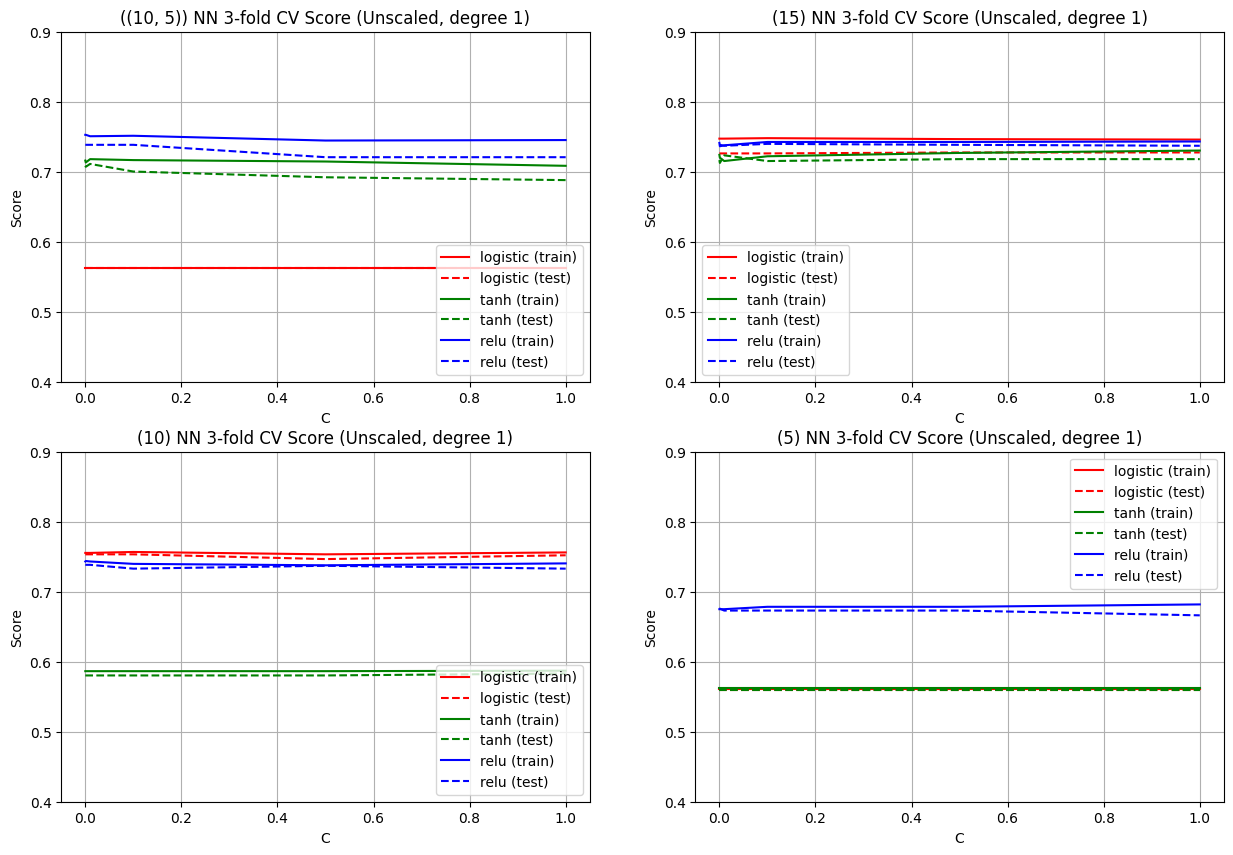

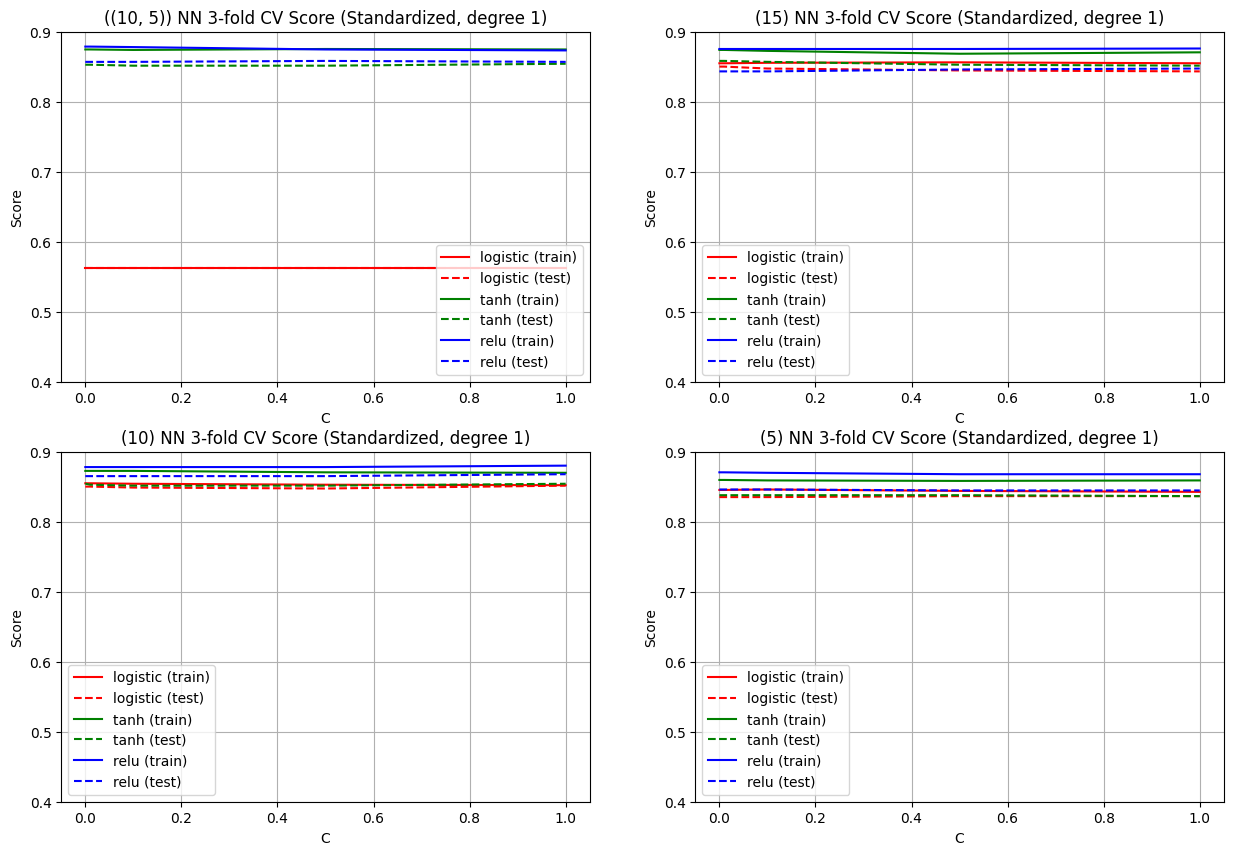

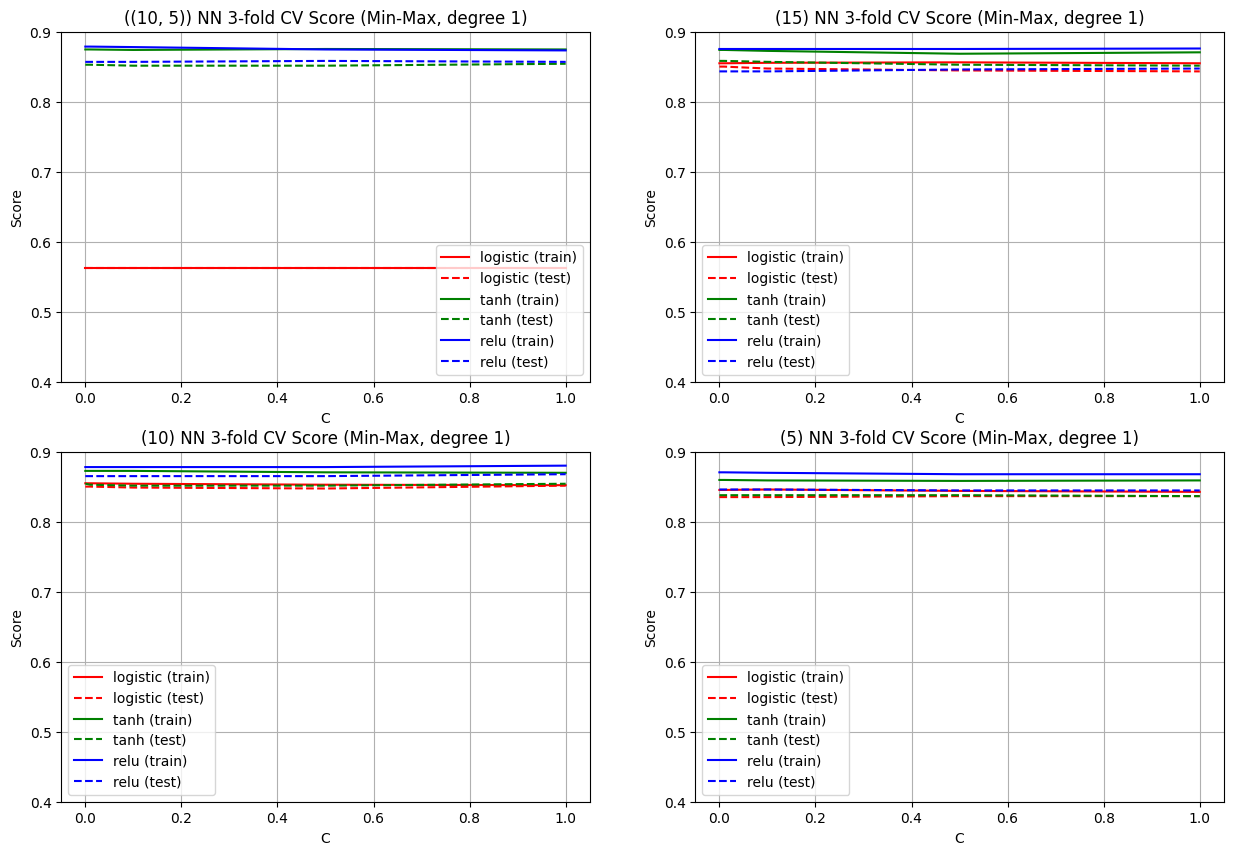

In [70]:
degree = 1
for (cv_results_, params), normalization in zip(cv_results_and_params[degree], ["Unscaled", "Standardized", "Min-Max"]):
    plot_nn_cv_results(cv_results_, params, normalization, degree)

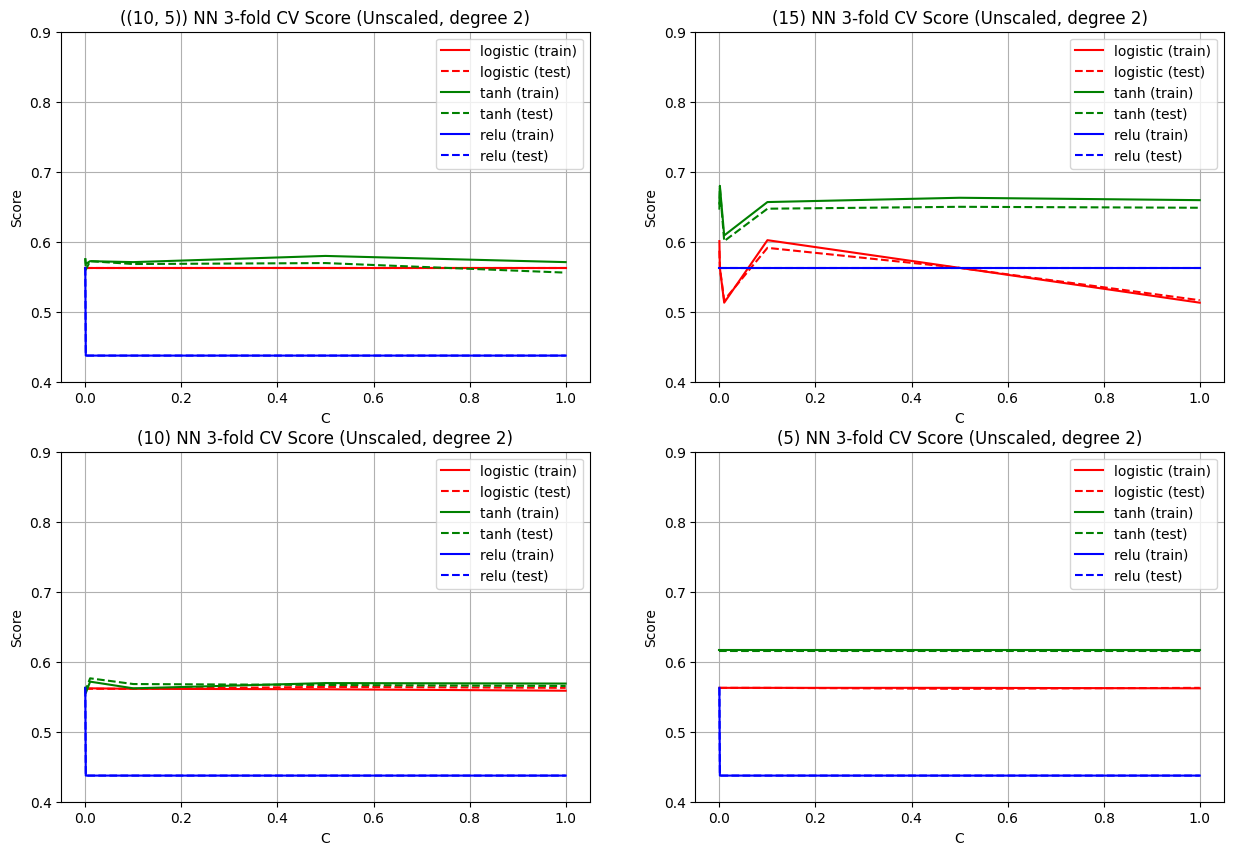

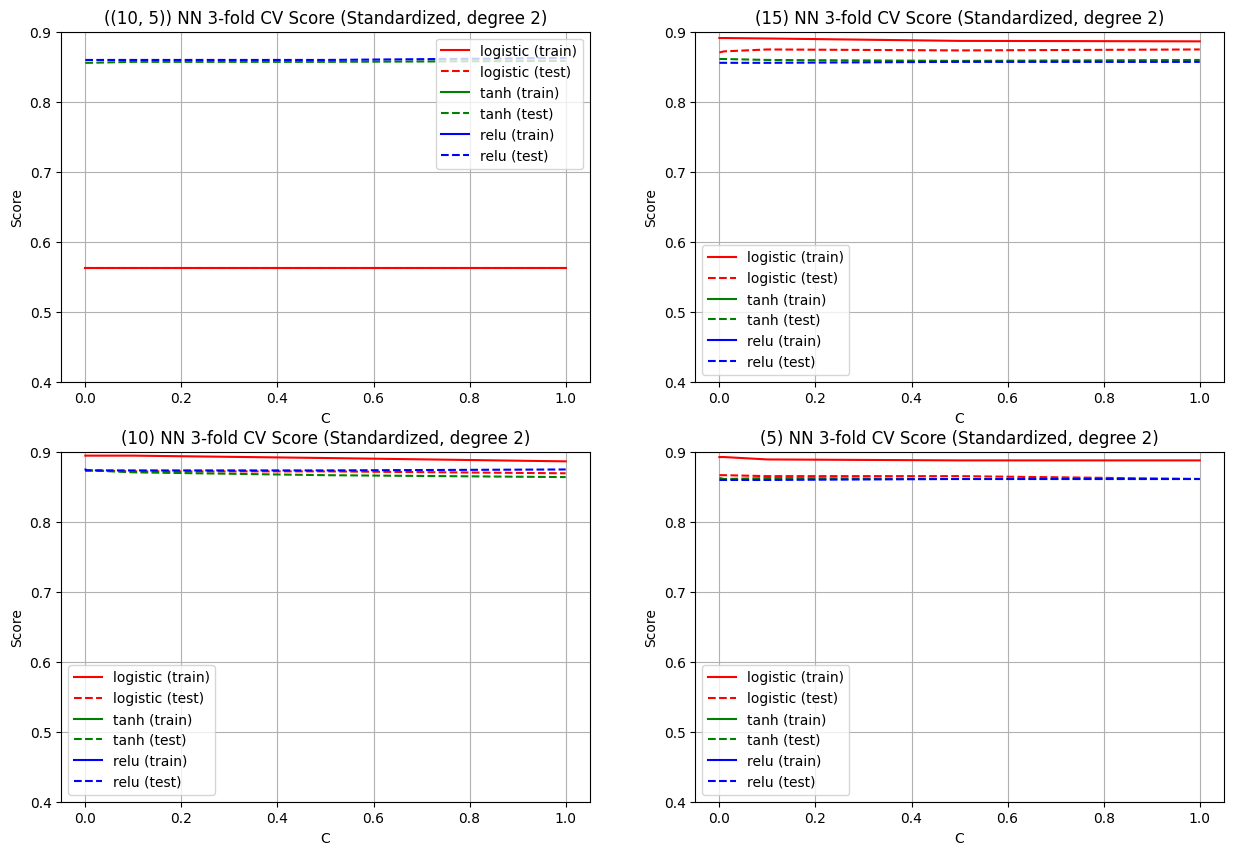

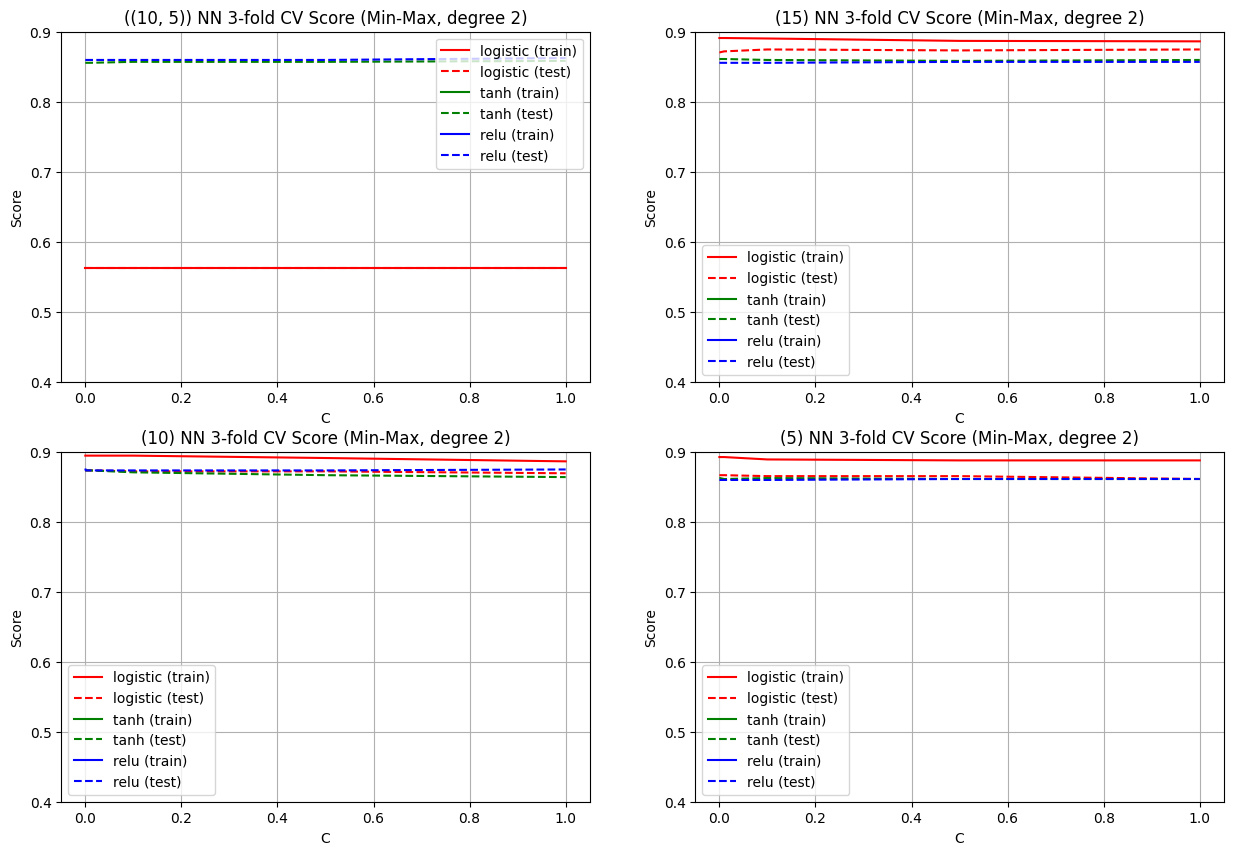

In [71]:
degree = 2
for (cv_results_, params), normalization in zip(cv_results_and_params[degree], ["Unscaled", "Standardized", "Min-Max"]):
    plot_nn_cv_results(cv_results_, params, normalization, degree)

Best performance from tests: ~85% from a neural network with one hidden layer made up of 10 neurons using ReLU as an activation function with L2 regularization ($\alpha=1$) on standardized or min-max scaled data.